# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [20]:
import numpy as np
import pandas as pd
import random as random
import itertools as itertools
import pickle
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
from copy import deepcopy
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


In [2]:
df_train = pd.read_csv('Higgs_train.csv')
df_test = pd.read_csv('Higgs_test.csv')
df_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.376816,-1.583727,-1.707552,0.990897,0.114397,1.253553,0.619859,-1.479572,2.173076,0.753658,...,0.397156,0.000000,0.522449,1.318622,0.982398,1.359610,0.964809,1.309991,1.083203,1.0
1,0.707330,0.087603,-0.399742,0.918742,-1.229936,1.172847,-0.552574,0.886053,2.173076,1.298317,...,0.236231,0.000000,0.439696,0.828885,0.992241,1.157820,2.215780,1.189586,0.937976,1.0
2,0.617290,0.265839,-1.345227,1.154581,1.036646,0.954822,0.377252,-0.147960,0.000000,1.063507,...,-0.542413,0.000000,1.024506,1.026255,0.986289,0.927720,1.371080,0.981672,0.917436,1.0
3,0.850992,-0.380876,-0.071264,1.468704,-0.795133,0.691818,0.883260,0.496881,0.000000,1.616349,...,-1.520171,0.000000,1.197755,1.100534,0.987262,1.353453,1.455383,0.994682,0.953553,1.0
4,0.767540,-0.691572,-0.040191,0.614843,0.143765,0.748614,0.397057,-0.873640,0.000000,1.147862,...,0.502034,1.550981,0.921948,0.864080,0.982839,1.373222,0.601492,0.918621,0.957063,0.0


In [3]:
# splitting into x and y training and testing
x_train = df_train.loc[:, df_train.columns != ' class']
y_train = df_train[" class"]
x_test = df_test.loc[:, df_test.columns != ' class']
y_test = df_test[' class']

## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [4]:
#Decision tree with CV to determine best depth (found to be 4)
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
tree_scores = dict()
for i, d in enumerate(depths):
    tree_model =  DecisionTreeClassifier(max_depth = d, random_state = 1)
    scores = cross_val_score(tree_model, x_train, y_train)
    tree_scores[str(d)] = np.mean(scores)
tree_scores

{'10': 0.60780235355533108,
 '2': 0.62200179832124691,
 '3': 0.62199795985540496,
 '4': 0.63620340222419902,
 '5': 0.63180308094460802,
 '6': 0.62540651752307641,
 '7': 0.62060147800127252,
 '8': 0.61520051665750231,
 '9': 0.6146038751231907}

In [5]:
tree_model =  DecisionTreeClassifier(max_depth = 4, random_state = 1)
tree_model.fit(x_train, y_train)
tree_model.score(x_test, y_test)

0.64959999999999996

## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

In [6]:
def flip(probability):
    return 0 if random.random() < probability else 1

In [7]:
#function creates b new sets with probability p to determine the new columns
def create_sets(train, test, p, b):
    set_list = []
    for i in range(b):
        new_columns = []
        while len(new_columns) == 0:
            for c in train.columns:
                if flip(p) == 1:
                    new_columns.append(c)
        set_list.append((train[new_columns], test[new_columns]))
    return set_list

In [8]:
def model_array(train_list, train_y):
    m_array = []
    count = 0
    for train in train_list:
        tree_model = DecisionTreeClassifier(max_depth = 4, random_state = 1)
        tree_model.fit(train, train_y)
        m_array.append(deepcopy(tree_model))
    return m_array

In [9]:
def ensemble_classifier(m_array, x_list):
    ps = []
    predictions = []
    for m, test in zip(m_array, x_list):
        p1 = m.predict(test)
        ps.append(p1)
    for i in range(len(ps[0])):
        voting = []
        for p in ps:
            voting.append(p[i])
        if np.mean(voting) >= 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [10]:
tree_counts = [2**x for x in range(1, 9)]
c_scores = dict()
for count in tree_counts:
    set_list = create_sets(x_train, x_test, 0.5, count)
    train_list = [x[0] for x in set_list]
    test_list = [x[1] for x in set_list]
    m = model_array(train_list, y_train)
    train_predictions = ensemble_classifier(m, train_list)
    test_predictions = ensemble_classifier(m, test_list)
    c_scores[str(count)] = (metrics.accuracy_score(y_train, train_predictions), metrics.accuracy_score(y_test, test_predictions)) 
c_scores

{'128': (0.68379999999999996, 0.66139999999999999),
 '16': (0.67500000000000004, 0.65680000000000005),
 '2': (0.66279999999999994, 0.63959999999999995),
 '256': (0.67920000000000003, 0.66039999999999999),
 '32': (0.68120000000000003, 0.65559999999999996),
 '4': (0.64600000000000002, 0.624),
 '64': (0.67700000000000005, 0.65700000000000003),
 '8': (0.66720000000000002, 0.6522)}

Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- An increase in the number of trees does not necessarily improve the training and test performance. This is shown clearly in the dictionary above, when we use 256 trees instead of 128 and both the training and test scores decrease. This turning point where the scores cease increasing shows where the bias-variance trade-off happens. As we average more trees the variance of our model decreases and at a certain point we reach hit a plateau of training and testing scores, where an increase in the number of trees does not have a perceptible effect on the scores and our model is limited by its fundamental bias.

In [11]:
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
p_scores = dict()
for prob in probabilities:
    set_list = create_sets(x_train, x_test, prob, 64)
    train_list = [x[0] for x in set_list]
    test_list = [x[1] for x in set_list]
    m = model_array(train_list, y_train)
    train_predictions = ensemble_classifier(m, train_list)
    test_predictions = ensemble_classifier(m, test_list)
    p_scores[str(prob)] = (metrics.accuracy_score(y_train, train_predictions), metrics.accuracy_score(y_test, test_predictions)) 
p_scores = sorted(p_scores.items())
p_scores

[('0.1', (0.66020000000000001, 0.64959999999999996)),
 ('0.3', (0.66679999999999995, 0.65180000000000005)),
 ('0.5', (0.67859999999999998, 0.65700000000000003)),
 ('0.7', (0.69520000000000004, 0.66479999999999995)),
 ('0.9', (0.54620000000000002, 0.54139999999999999))]

Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Our results show that the accuracy of our ensemble classifier increases as the dropout rate increases up to a point. Similar to the pattern we observed when we were looking at the number of trees, the scores begin to decrease once the dropout rate gets as high as 0.9. This happens because when the dropout rate increases, the bias of our ensemble model decreases due to the fact that there are more possible models that we can create. However, when the dropout rate increases to a certain point the accuracy decreases, because each of our models do not have enough predictors to make accurate predictions. 

In [12]:
#CV to determine best p and b combo
#tree_counts1 only goes to 64 trees to avoid lenghty computation times
tree_counts1 = [2**x for x in range(1, 7)]
combinations = list(itertools.product(probabilities, tree_counts1))
combo_scores = dict()
for p, b in combinations:
    scores = []
    train_sets = [x[0] for x in create_sets(x_train, x_test, p, b)]
    for train, valid in KFold(5, shuffle=False).split(range(5000)):
        train_list1 = []
        test_list1 = []
        ny_train = y_train[train]
        ny_test = y_train[valid]
        for s in train_sets:
            nx_train = s.iloc[train]
            nx_test = s.iloc[valid]
            train_list1.append(nx_train)
            test_list1.append(nx_test)
        m = model_array(train_list1, ny_train)
        test_predictions = ensemble_classifier(m, test_list1)
        scores.append(metrics.accuracy_score(ny_test, test_predictions))
    combo_scores[str(p) + ',' + str(b)] = np.mean(scores)
combo_scores

{'0.1,16': 0.6399999999999999,
 '0.1,2': 0.63640000000000008,
 '0.1,32': 0.6399999999999999,
 '0.1,4': 0.6399999999999999,
 '0.1,64': 0.6399999999999999,
 '0.1,8': 0.64700000000000002,
 '0.3,16': 0.64459999999999995,
 '0.3,2': 0.63840000000000008,
 '0.3,32': 0.64080000000000004,
 '0.3,4': 0.62859999999999994,
 '0.3,64': 0.64439999999999997,
 '0.3,8': 0.64060000000000006,
 '0.5,16': 0.64940000000000009,
 '0.5,2': 0.57899999999999996,
 '0.5,32': 0.65240000000000009,
 '0.5,4': 0.63560000000000005,
 '0.5,64': 0.64700000000000002,
 '0.5,8': 0.63840000000000008,
 '0.7,16': 0.63739999999999997,
 '0.7,2': 0.59939999999999993,
 '0.7,32': 0.64639999999999997,
 '0.7,4': 0.62560000000000004,
 '0.7,64': 0.6532,
 '0.7,8': 0.63200000000000001,
 '0.9,16': 0.57440000000000002,
 '0.9,2': 0.53180000000000016,
 '0.9,32': 0.5766,
 '0.9,4': 0.53580000000000005,
 '0.9,64': 0.5514,
 '0.9,8': 0.5776}

In [13]:
#the best combination found by our model is p = 0.5 and b = 16
set_list = create_sets(x_train, x_test, 0.5, 16)
train_list = [x[0] for x in set_list]
test_list = [x[1] for x in set_list]
m = model_array(train_list, y_train)
test_predictions = ensemble_classifier(m, test_list)
metrics.accuracy_score(y_test, test_predictions)
#this test performance is better than what we got in part 1

0.65239999999999998

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





How does a random forest approach differ from the dropout procedure described in Question 2?
- The random forest approach is much different, because rather than dropping certain predictors, different decision trees are built using different samples that are obtained through bootstrapping.

In [14]:
#the square root of 28 is about 5, so we use 5 predictors for each tree
tree_counts2 = [2**x for x in range(1, 9)]
train_scores = dict()
test_scores = dict()
for c in tree_counts2:
    rand_forest = RandomForestClassifier(n_estimators = c, max_features = 5, random_state = 1)
    rand_forest.fit(x_train, y_train)
    tr_pred = rand_forest.predict(x_train)
    tst_pred = rand_forest.predict(x_test)
    train_scores[str(c)] = metrics.accuracy_score(y_train, tr_pred)
    test_scores[str(c)] = metrics.accuracy_score(y_test, tst_pred)
test_scores

{'128': 0.70279999999999998,
 '16': 0.66800000000000004,
 '2': 0.58179999999999998,
 '256': 0.70299999999999996,
 '32': 0.68300000000000005,
 '4': 0.61319999999999997,
 '64': 0.69199999999999995,
 '8': 0.64239999999999997}

In [15]:
train_scores

{'128': 1.0,
 '16': 0.998,
 '2': 0.85099999999999998,
 '256': 1.0,
 '32': 0.99980000000000002,
 '4': 0.92879999999999996,
 '64': 1.0,
 '8': 0.98140000000000005}

Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier.
- We found in our results that a larger number of trees does necessarily improve the test accuracy of a random forest, although the rate of improvement seems to slow dramatically as the number of trees increases. This happens, because there are only so many possible subsamples of the data and therefore only so many possible trees. So after a certain number of trees we will just be getting the same trees repeated in the same proportions and therefore our scores will plateau. 

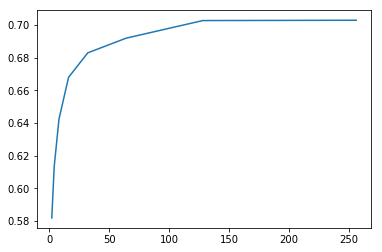

In [16]:
#plot of test scores vs. number of trees
x1, y1 = zip(*test_scores.items())
plt.plot(x1, y1)

Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?

In [17]:
#fixing the number of trees to 64, because it's accuracy is very close to that of a forest with 128 trees, but will be less expensive
feature_count = np.arange(1, 29)
fscores = dict()
for f in feature_count:
    rand_forest = RandomForestClassifier(n_estimators = 64, max_features = f, random_state = 1)
    scores = cross_val_score(rand_forest, x_train, y_train)
    fscores[str(f)] = np.mean(scores)
fscores

{'1': 0.64059820570914217,
 '10': 0.67260141466658607,
 '11': 0.68320445684268927,
 '12': 0.67320261437908491,
 '13': 0.67640173575425377,
 '14': 0.6777996570330771,
 '15': 0.66980461249247902,
 '16': 0.67300205453884188,
 '17': 0.673401015082292,
 '18': 0.67060133405880329,
 '19': 0.67380309437923847,
 '2': 0.66000021111562124,
 '20': 0.67179869549738358,
 '21': 0.67540061588184441,
 '22': 0.66359925265070052,
 '23': 0.67080357322785222,
 '24': 0.67359941578549887,
 '25': 0.66800077345086706,
 '26': 0.67020189370712313,
 '27': 0.66840045370666257,
 '28': 0.67180157434676513,
 '3': 0.66439933287463659,
 '4': 0.67520125556217681,
 '5': 0.67699789748033512,
 '6': 0.67319613696797675,
 '7': 0.6806029366182923,
 '8': 0.67740285562666314,
 '9': 0.67179893540149882}

In [18]:
#the best number of features we found was 11 and the best practical number of trees we found was 128
rand_forest = RandomForestClassifier(n_estimators = 128, max_features = 11, random_state = 1)
rand_forest.fit(x_train, y_train)
tst_pred = rand_forest.predict(x_test)
optimal_rand_forest_score = metrics.accuracy_score(y_test, tst_pred)
optimal_rand_forest_score

0.70140000000000002

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



In [21]:
# is n_estimators = 100 good? I can't put none in depths_ada because I can't plot... how do I show unrestricted depth?
boost_train_score_dep = dict()
boost_train_score_num = dict()
boost_test_score_dep = dict()
boost_test_score_num = dict()
depths_ada = [1, 2, 10]
tree_counts3 = [2**x for x in range(1,9)]
for i, d in enumerate(depths_ada): 
    for c in tree_counts3: 
        adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=d), n_estimators=c, learning_rate=0.05)
        adaboost.fit(x_train, y_train)
        sc_train = adaboost.score(x_train, y_train)
        sc_test = adaboost.score(x_test, y_test)
        boost_train_score_dep[str(d)] = sc_train
        boost_train_score_num[str(c)] = sc_train
        boost_test_score_dep[str(d)] = sc_train
        boost_test_score_num[str(c)] = sc_test
print("Train Score as a function of depth", boost_train_score_dep)
print("")
print("Train Score as a function of number of trees", boost_train_score_num)
print("")
print("Test Score as a function of depth", boost_test_score_dep)
print("")
print("Test Score as a function of number of trees", boost_test_score_num)

Train Score as a function of depth {'1': 0.68079999999999996, '2': 0.74019999999999997, '10': 1.0}

Train Score as a function of number of trees {'2': 0.91679999999999995, '4': 0.9718, '8': 0.99180000000000001, '16': 0.99680000000000002, '32': 1.0, '64': 1.0, '128': 1.0, '256': 1.0}

Test Score as a function of depth {'1': 0.68079999999999996, '2': 0.74019999999999997, '10': 1.0}

Test Score as a function of number of trees {'2': 0.61760000000000004, '4': 0.61399999999999999, '8': 0.60140000000000005, '16': 0.60360000000000003, '32': 0.62339999999999995, '64': 0.62119999999999997, '128': 0.64959999999999996, '256': 0.64339999999999997}


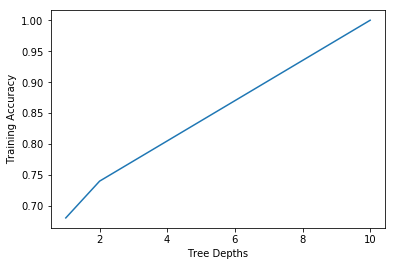

In [22]:
x2, y2 = zip(*boost_train_score_dep.items())
plt.plot(x2, y2)
plt.ylabel('Training Accuracy')
plt.xlabel('Tree Depths');

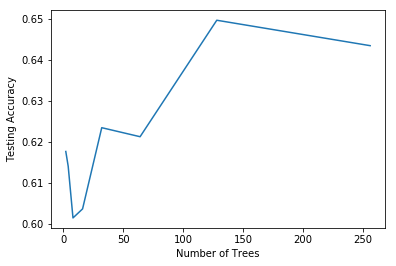

In [23]:
x3, y3 = zip(*boost_test_score_num.items())
plt.plot(x3, y3)
plt.ylabel('Testing Accuracy')
plt.xlabel('Number of Trees');

How does the number of trees influence the training and test performance? 
<tr>
As the number of trees increases, the training performance increases in accuracy. It starts 0.912 accuracy with 2 trees and reaches 1 when number of trees are greater than 64. The testing performance follows a similar increasing trend, but starts with 0.62 accuracy with 2 trees and reaches 0.6588 accuracy with 256 trees. A similar trend is found in the results on question 3, yet, for example, the testing accuracy is able to reach 0.7 accuracy. 

How does the tree depth of the base learner impact the training and test performance? 
<tr>
As the depth of the base learner increases, the training accuracy increases steadily from 0.68 when depth is set to 1 to 1 when depth is set to 10. The testing accuracy instead increases at a similar rate, starting at 0.68 with the depth set at 1 to reaching 1 when depth is set to 10 as well. 

Apply 5-fold cross-validation to choose the optimal number of trees for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4?

In [24]:
tree_counts4 = [2**x for x in range(1,9)]
depths_ada = [1, 2, 10]
combin = list(itertools.product(depths_ada, tree_counts4))
com_score = dict()
for dep, num in combin: 
    adaboost1 = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=dep), n_estimators=num, learning_rate=0.05)
    ada_scr = cross_val_score(adaboost1, x_train, y_train)
    com_score[str(dep) + ',' + str(num)] = np.mean(ada_scr)
com_score

{'1,128': 0.65020180734164168,
 '1,16': 0.59920347035696775,
 '1,2': 0.60020387051703172,
 '1,256': 0.66280085175557035,
 '1,32': 0.61520003684927216,
 '1,4': 0.60020387051703172,
 '1,64': 0.64160244433504809,
 '1,8': 0.60020387051703172,
 '10,128': 0.63200388068896618,
 '10,16': 0.59320514776654065,
 '10,2': 0.61460843330137804,
 '10,256': 0.64440116574207618,
 '10,32': 0.61000299400335678,
 '10,4': 0.60640947026292535,
 '10,64': 0.61660635477212467,
 '10,8': 0.59099970923621248,
 '2,128': 0.67520029594571651,
 '2,16': 0.64300348436736809,
 '2,2': 0.62100139816118294,
 '2,256': 0.67740069648962697,
 '2,32': 0.64640076654162859,
 '2,4': 0.62100139816118294,
 '2,64': 0.66139981172325057,
 '2,8': 0.6254031588654646}

In [25]:
#the best combination of depth and number of trees that we found was 2 and 256
adaboost_optimal = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2), n_estimators=256, learning_rate=0.05)
adaboost_optimal.fit(x_train, y_train)
ada_pred = adaboost.predict(x_test)
optimal_ada = adaboost.score(x_train, ada_pred)
optimal_ada

0.50960000000000005

- Similar to Question 3.4, the optimal number of trees for AdaBoost is the highest number tested (256).

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



- Our strategy is to use each of the models as a predictor and build a logistic regression model with cross-validation that uses the predictions of the other models to make a final prediction.

In [26]:
models = np.load('models.npy', encoding = 'latin1')

In [27]:
#this function takes x's and a list of models and returns a dict with the number of the model as the key and the list of 
#predictions as the value
def model_dict(x, model_list):
    models_dict = dict()
    for m in range(len(model_list)):
        predictions = model_list[m].predict(x)
        models_dict[m] = predictions
    return models_dict

In [28]:
train_dict = model_dict(x_train, models)
test_dict = model_dict(x_test, models)
mx_train= pd.DataFrame.from_dict(train_dict)
mx_test = pd.DataFrame.from_dict(test_dict)
mx_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [29]:
meta_classifier = LogisticRegressionCV(cv = 5, penalty = 'l2')
meta_classifier.fit(mx_train, y_train)
meta_classifier.score(mx_test, y_test)

0.68959999999999999

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.
